In [1]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=3SDhbo8lOBQv

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

import tempfile
model_dir = tempfile.mkdtemp()

In [2]:
data_dir = pathlib.Path("./data/dogs-vs-cats/")

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))

In [4]:
SEED = 0
EPOCH_SIZE = 5
BATCH_SIZE = 32
BUFFER_SIZE= BATCH_SIZE * 5
IMG_HEIGHT = 128
IMG_WIDTH = 128
STEPS_PER_EPOCH = image_count//BATCH_SIZE
CLASS_NAMES = np.array(["cat", "dog"])

tf.random.set_seed(SEED)

In [5]:
def get_label(path):
    s_path = tf.strings.split(path, os.path.sep)[-1]
    label = tf.strings.split(s_path, ".")[0]
    return label == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(path):
    label = get_label(path)
    img = tf.io.read_file(path)
    img = decode_img(img)
    return img, label

def scale_image(image, label):
    image = tf.image.per_image_standardization(image)
    return image, label

In [1]:
def input_fn(path):
    list_ds = tf.data.Dataset.list_files(str(path))
    
    return list_ds \
        .map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .map(scale_image) \
        .shuffle(BUFFER_SIZE) \
        .batch(BATCH_SIZE) \
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE) \
        .repeat(EPOCH_SIZE)

for image, label in input_fn(data_dir/'*/*').take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.shape)

NameError: name 'data_dir' is not defined

In [7]:
train_ds = input_fn(data_dir/'*/*')

In [8]:
def model_fn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.MaxPool2D(strides=2),
        tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'),
        tf.keras.layers.MaxPool2D(strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer=tf.optimizers.Adam(lr=5e-4),
                  loss=tf.losses.CategoricalCrossentropy(), 
                  metrics=["accuracy"])
    
    return model

In [9]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               11059456  
_________________________________________________________________
dense_1 (Dense)              (None, 84)                2

In [10]:
history = model.fit(train_ds, epochs = EPOCH_SIZE, steps_per_epoch = STEPS_PER_EPOCH, use_multiprocessing=True, workers=7)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 388s 497ms/step - loss: 0.6429 - accuracy: 0.6258
Epoch 2/5
781/781 [==============================] - 385s 492ms/step - loss: 0.4837 - accuracy: 0.7682
Epoch 3/5
781/781 [==============================] - 383s 491ms/step - loss: 0.3527 - accuracy: 0.8452
Epoch 4/5
781/781 [==============================] - 389s 498ms/step - loss: 0.1598 - accuracy: 0.9398
Epoch 5/5
781/781 [==============================] - 396s 507ms/step - loss: 0.0391 - accuracy: 0.9871


In [11]:
acc = history.history['accuracy']
loss=history.history['loss']

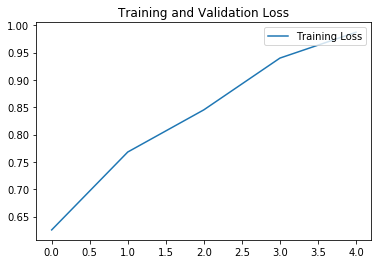

In [12]:
epochs_range = range(EPOCH_SIZE)
# plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model.evaluate(train_ds, steps=20)

20/20 [==============================] - 3s 152ms/step - loss: 0.0192 - accuracy: 0.9953


[0.01915243990952149, 0.9953125]

In [14]:
pred = model.predict(train_ds, steps=30)

In [15]:
print(np.argmax(pred, axis=1))

[0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0
 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0
 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0
 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1
 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0
 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0
 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0
 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1
 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0
 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0
 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1
 0 1 0 0 1 0 0 1 0 1 1 0 